# HOG Feature Extraction with Support Vector Regression

This notebook implements fiber orientation prediction using:
1. HOG (Histogram of Oriented Gradients) for feature extraction
2. SVR (Support Vector Regression) for angle prediction

This implementation uses the functions from our src/fiber_predictor package.

In [38]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../src'))

# Import from our package
from fiber_predictor.svr_hog.feature_extraction import HogFeatureExtractor
from fiber_predictor.svr_hog.data_processing import HogDataset, balance_dataset
from fiber_predictor.svr_hog.models import FiberPredictor

## 1. Data Loading and Processing

In [39]:
# Dataset parameters
grid_quotient = np.arange(1, 6)  # Multiple grid sizes for better features
orientations = 8

# Create datasets
bio_file_dir = "../images/bio/"
bio_csv_dir = "../images/bio/labels.csv"

# Load biological dataset with augmentation
bio_dataset = HogDataset(
    labels_path=bio_csv_dir,
    file_dir=bio_file_dir,
    grid_quotient=grid_quotient,
    orientations=orientations,
    augment_whole_dataset=True
)

print(f"Total biological samples: {len(bio_dataset)}")

Total biological samples: 4711


## 2. Data Balancing

Dataset size before balancing: 4711
Dataset size after balancing: 1008


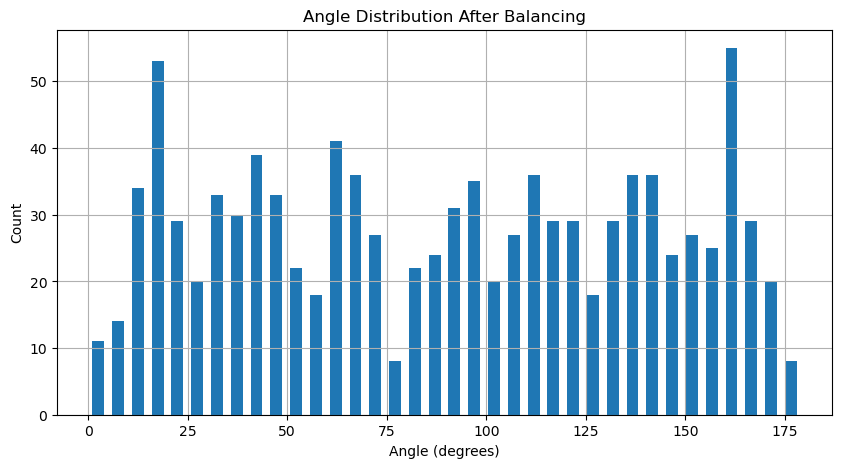

In [40]:
# Balance the dataset
bins = np.arange(0, 181, 20)  # 20-degree bins so the dataset is not reduced too much
print("Dataset size before balancing:", len(bio_dataset))

balance_dataset(bio_dataset, bins)
print("Dataset size after balancing:", len(bio_dataset))

# Visualize angle distribution
plt.figure(figsize=(10, 5))
plt.hist(bio_dataset.labels, bins=36, rwidth=0.6)  # rwidth sets the relative width of the bars
plt.title('Angle Distribution After Balancing')
plt.xlabel('Angle (degrees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## 3. Feature Extraction and Data Preparation

In [41]:
# Extract features for all images
hog_extractor = HogFeatureExtractor(grid_quotient, orientations)
feature_matrix = []
labels = []

for idx in range(len(bio_dataset)):
    img_tensor, features_tensor, angle = bio_dataset[idx]
    feature_matrix.append(features_tensor.numpy())
    labels.append(angle)

feature_matrix = np.array(feature_matrix)
labels = np.array(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, 
    labels, 
    test_size=0.3, 
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Feature vector dimension: {X_train.shape[1]}")

Training set size: 705
Test set size: 303
Feature vector dimension: 440


## 4. Model Training and Evaluation

In [42]:
# Initialize and train model
model = FiberPredictor(
    scaler_type="Standard",
    pca_params={"n_components": 0.8},
    regressor_type="SVR",
    regressor_params={"kernel": "rbf", "C": 100, "gamma": 0.01}
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}°")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error: 12.18°
R² Score: 0.787


## 5. Results Visualization

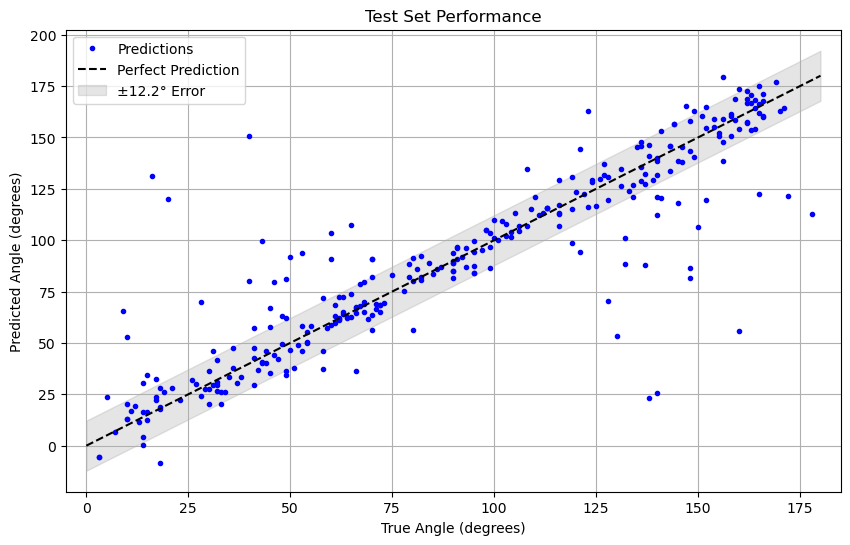

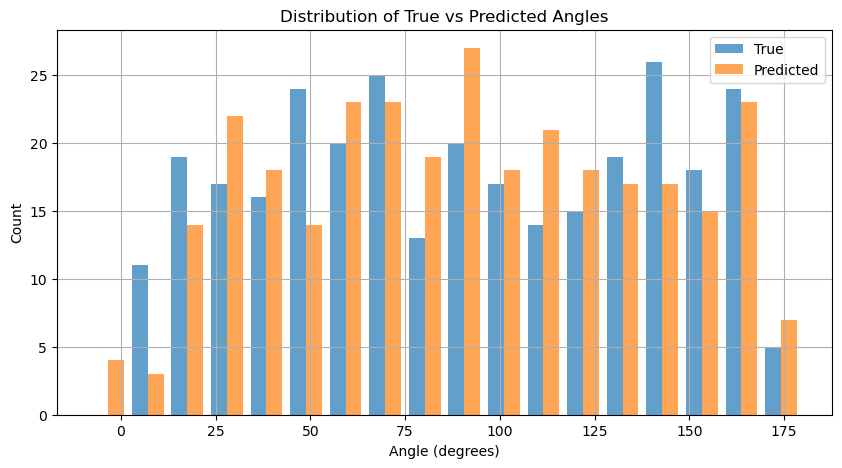

In [43]:
def plot_angle_predictions(true_angles, pred_angles, mae, title="Model Predictions vs True Values"):
    """Plot predicted vs true angles with error bounds"""
    plt.figure(figsize=(10, 6))
    plt.plot(true_angles, pred_angles, 'b.', label='Predictions')
    plt.plot([0, 180], [0, 180], 'k--', label='Perfect Prediction')
    plt.fill_between(np.array([0, 180]), 
                     np.array([0, 180])-mae, 
                     np.array([0, 180])+mae, 
                     color='gray', 
                     alpha=0.2, 
                     label=f'±{mae:.1f}° Error')

    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Predicted Angle (degrees)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim([-5, 185])
    plt.show()

# Plot test set results
plot_angle_predictions(y_test, y_pred, mae, "Test Set Performance")

# Distribution of predictions vs actual values
plt.figure(figsize=(10, 5))
plt.hist([y_test, y_pred], bins=18, 
         label=['True', 'Predicted'], 
         alpha=0.7)
plt.title('Distribution of True vs Predicted Angles')
plt.xlabel('Angle (degrees)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

## 6. Cross-Dataset Evaluation

Diffusion Dataset Performance:
Mean Absolute Error: 16.87°
R² Score: 0.762


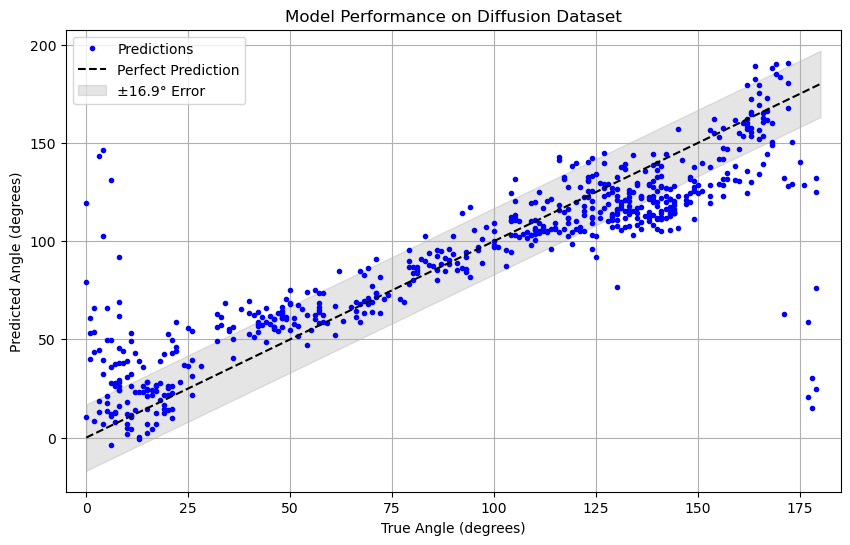

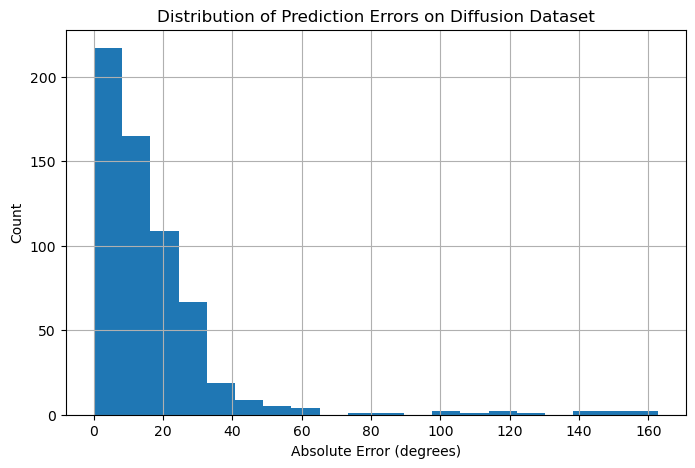

In [44]:
# Load diffusion dataset
diff_file_dir = "../images/diffusion/"
diff_csv_dir = "../images/diffusion/labels.csv"

diff_dataset = HogDataset(
    labels_path=diff_csv_dir,
    file_dir=diff_file_dir,
    grid_quotient=grid_quotient,
    orientations=orientations,
    augment_whole_dataset=False
)

# Extract features
diff_feature_matrix = []
diff_labels = []

for idx in range(len(diff_dataset)):
    img_tensor, features_tensor, angle = diff_dataset[idx]
    diff_feature_matrix.append(features_tensor.numpy())
    diff_labels.append(angle)

diff_feature_matrix = np.array(diff_feature_matrix)
diff_labels = np.array(diff_labels)

# Make predictions
diff_predictions = model.predict(diff_feature_matrix)
diff_mae = mean_absolute_error(diff_labels, diff_predictions)
diff_r2 = r2_score(diff_labels, diff_predictions)

print(f"Diffusion Dataset Performance:")
print(f"Mean Absolute Error: {diff_mae:.2f}°")
print(f"R² Score: {diff_r2:.3f}")

# Plot results
plot_angle_predictions(diff_labels, diff_predictions, diff_mae, 
                      "Model Performance on Diffusion Dataset")

# Plot error histogram
errors = np.abs(diff_predictions - diff_labels)
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=20)
plt.title('Distribution of Prediction Errors on Diffusion Dataset')
plt.xlabel('Absolute Error (degrees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()